# Loading

First we need to specify all the required packages to be able to use BERT and Tensorflow. We use numpy and pandas to load and change our data so that it can be handled by the BERT Tensorflow module. Furthermore, we drop all of the additional columns since we only really need the "comment_text" and "target" column to train our model.

In [4]:
import pandas as pd
import tensorflow as tf
import numpy as np

import os

import run_classifier
import tokenization
import modeling
import optimization

In [5]:
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

In [6]:
data = pd.read_csv("train.csv")
data = data.drop(['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
                  'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu', 'homosexual_gay_or_lesbian',
                  'intellectual_or_learning_disability', 'jewish', 'latino', 'male', 'muslim', 'other_disability', 
                  'other_gender', 'other_race_or_ethnicity', 'other_religion', 'other_sexual_orientation', 
                  'physical_disability', 'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date', 
                  'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow', 'sad', 'likes', 'disagree', 
                  'sexual_explicit', 'identity_annotator_count', 'toxicity_annotator_count'], axis=1)
data.head()

,id,target,comment_text
0,59848,0.000000,"This is so cool. It's like, 'would you want yo..."
1,59849,0.000000,Thank you!! This would make my life a lot less...
2,59852,0.000000,This is such an urgent design problem; kudos t...
3,59855,0.000000,Is this something I'll be able to install on m...
4,59856,0.893617,haha you guys are a bunch of losers.


In [8]:
data = data.sample(frac=0.5)

In [9]:
print("Mean value for the target column:  ", data["target"].mean())
print("Number of targets higher than 0.5: ", data[(data['target'] >0.5)]["target"].count())
print("Number of targets higher than 0.0: ", data[(data['target'] >0.0)]["target"].count())
print("Number of comments:                ", len(data))

Mean value for the target column:   0.1028532806939755
Number of targets higher than 0.5:  53073
Number of targets higher than 0.0:  269530
Number of comments:                 902437


In [10]:
data['label'] = np.where(data['target']>0,1,0)
label_list = list(data['label'].unique())
label_list
print("Number of targets higher than 0.0: ", data[(data['target'] >0.0)]["target"].count())

Number of targets higher than 0.0:  269530


In [11]:
# this is a fraction of the sample fraction. Essentially we should always keep this between 0.7-0.9
training_frac = 0.8
train_len = int(len(data)*training_frac)
valid_len = int(len(data)*(1.0-training_frac))

train = data.iloc[:train_len, :]
valid = data.iloc[:valid_len, :]

In [12]:
train0 = train[train["label"]==0]
train1 = train[train["label"]==1]
train0["count"] = train0['comment_text'].str.split().str.len()
train1["count"] = train1['comment_text'].str.split().str.len()

/home/jupyter/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jupyter/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


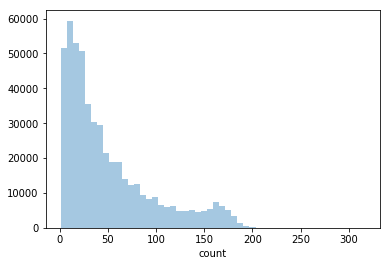

In [13]:
import seaborn as sns
x = pd.Series(train0["count"])
ax = sns.distplot(x, kde=False)

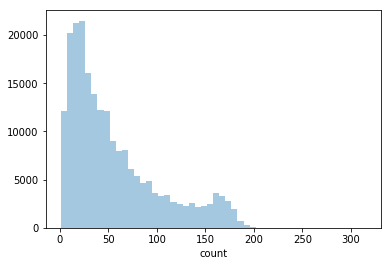

In [14]:
import seaborn as sns
x = pd.Series(train1["count"])
ax = sns.distplot(x, kde=False)

# Tokenizing

In [8]:
BERT_CONFIG_FILE = "./bert/bert_config.json"
INIT_CHECKPOINT = './bert/bert-model.ckpt'
VOCAB_FILE = "./bert/vocab.txt"
OUTPUT_DIR = './output4'
TRAIN_FILE = "./output4/train.tf_record"
VALID_FILE = "./output4/valid.tf_record"
DO_LOWER_CASE = False
DO_TRAIN = True
DO_EVAL = False
DO_PREDICT = False
USE_TPU = False
USE_ONE_HOT_EMBEDDING = False
MAX_SEQ_LENGTH = 512
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 32
PREDICT_BATCH_SIZE = 32
LEARNING_RATE = 2e-5 
NUM_TRAIN_EPOCHS = 1.0
WARMUP_PROPORTION = 0.1
MASTER = None
SAVE_CHECKPOINTS_STEPS = 5000
ITERATIONS_PER_LOOP = 1000
NUM_TPU_CORES = 1
TPU_CLUSTER_RESOLVER = None
IS_PER_HOST = tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [9]:
tokenizer = tokenization.FullTokenizer(vocab_file=VOCAB_FILE, do_lower_case=DO_LOWER_CASE)

In [10]:
def convert_input(x):
    return run_classifier.InputExample(guid=x["id"], 
                                       text_a = x["comment_text"],
                                       text_b = None, 
                                       label = x["label"])

In [11]:
train_InputExamples = train.apply(convert_input, axis= 1)
valid_InputExamples = valid.apply(convert_input, axis= 1)

In [12]:
run_classifier.file_based_convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer, TRAIN_FILE)
run_classifier.file_based_convert_examples_to_features(valid_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer, VALID_FILE)

INFO:tensorflow:Writing example 0 of 18048
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: 59848
INFO:tensorflow:tokens: [CLS] This is so cool . It ' s like , ' would you want your mother to read this ? ? ' Really great idea , well done ! [SEP]
INFO:tensorflow:input_ids: 101 1188 1110 1177 4348 119 1135 112 188 1176 117 112 1156 1128 1328 1240 1534 1106 2373 1142 136 136 112 8762 1632 1911 117 1218 1694 106 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [13]:
NUM_TRAIN_STEPS = int(len(train_InputExamples) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
NUM_WARMUP_STEPS = int(NUM_TRAIN_STEPS * WARMUP_PROPORTION)

# Training

In [ ]:
bert_config = modeling.BertConfig.from_json_file(BERT_CONFIG_FILE)

tpu_config = tf.contrib.tpu.TPUConfig(
    iterations_per_loop=ITERATIONS_PER_LOOP,
    num_shards=NUM_TPU_CORES,
    per_host_input_for_training=IS_PER_HOST)

run_config = tf.contrib.tpu.RunConfig(
    cluster=TPU_CLUSTER_RESOLVER,
    master=MASTER,
    model_dir=OUTPUT_DIR,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tpu_config)

model_fn = run_classifier.model_fn_builder(
    bert_config=bert_config,
    num_labels=len(label_list),
    init_checkpoint=INIT_CHECKPOINT,
    learning_rate=LEARNING_RATE,
    num_train_steps=NUM_TRAIN_STEPS,
    num_warmup_steps=NUM_WARMUP_STEPS,
    use_tpu=USE_TPU,
    use_one_hot_embeddings=USE_ONE_HOT_EMBEDDING)

estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=USE_TPU,
    model_fn=model_fn,
    config=run_config,
    train_batch_size=TRAIN_BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE,
    predict_batch_size=PREDICT_BATCH_SIZE)  

train_input_fn = run_classifier.file_based_input_fn_builder(
    input_file=TRAIN_FILE,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

In [ ]:
estimator.train(input_fn=train_input_fn, max_steps=NUM_TRAIN_STEPS)

# Evaluation

In [14]:
valid_input_fn = run_classifier.file_based_input_fn_builder(
    input_file=VALID_FILE, 
    seq_length=MAX_SEQ_LENGTH, 
    is_training=False, 
    drop_remainder=False)

In [15]:
bert_config = modeling.BertConfig.from_json_file(BERT_CONFIG_FILE)

INIT_CHECKPOINT = './output2/model.ckpt-45121'

tpu_config = tf.contrib.tpu.TPUConfig(
    iterations_per_loop=ITERATIONS_PER_LOOP,
    num_shards=NUM_TPU_CORES,
    per_host_input_for_training=IS_PER_HOST)

run_config = tf.contrib.tpu.RunConfig(
    cluster=TPU_CLUSTER_RESOLVER,
    master=MASTER,
    model_dir=OUTPUT_DIR,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tpu_config)

model_fn = run_classifier.model_fn_builder(
    bert_config=bert_config,
    num_labels=len(label_list),
    init_checkpoint=INIT_CHECKPOINT,
    learning_rate=LEARNING_RATE,
    num_train_steps=NUM_TRAIN_STEPS,
    num_warmup_steps=NUM_WARMUP_STEPS,
    use_tpu=USE_TPU,
    use_one_hot_embeddings=USE_ONE_HOT_EMBEDDING)

estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=USE_TPU,
    model_fn=model_fn,
    config=run_config,
    train_batch_size=TRAIN_BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE,
    predict_batch_size=PREDICT_BATCH_SIZE) 

INFO:tensorflow:Using config: {'_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_num_ps_replicas': 0, '_log_step_count_steps': None, '_num_worker_replicas': 1, '_model_dir': './output2/', '_protocol': None, '_save_summary_steps': 100, '_save_checkpoints_secs': None, '_global_id_in_cluster': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6fc6adc198>, '_tf_random_seed': None, '_evaluation_master': '', '_cluster': None, '_eval_distribute': None, '_task_id': 0, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': 5000, '_service': None, '_experimental_distribute': None, '_is_chief': True, '_tpu_config': TPUConfig(iterations_per_loop=1000, num_shards=1, num_cores_per_replica=None, per_host_input_for_training=3, tpu_job_name=None, initial_infeed_sleep_secs=None, input_partition_dims=None), '_task_type': 'worker', '_device_fn': None, '_train_distribute': None, '_ma

In [16]:
estimator.evaluate(input_fn=valid_input_fn, steps=None)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use `tf.data.experimental.map_and_batch(...)`.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running eval on CPU
INFO:tensorflow:*** Features ***
INFO:tensorflow:  name = input_ids, shape = (?, 512)
INFO:tensorflow:  name = input_mask, shape = (?, 512)
INFO:tensorflow:  name = is_real_example, shape = (?,)
INFO:tensorflow:  name = label_ids, shape = (?,)
INFO:tensorflow:  name = segment_ids, shape = (?, 512)
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to 

{'eval_accuracy': 0.97606385,
 'eval_loss': 0.08503706,
 'global_step': 45121,
 'loss': 0.08503706}